### Compute AVO attributes from the Near and Far volumes available from  Avseth et al. (2010)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import segyio
import xarray as xr

%matplotlib inline

Read the data and get infos

In [2]:
def read_segy(f ,byte_il=189, byte_xl=193):
    with segyio.open(f, iline=byte_il, xline=byte_xl) as segyfile:
        sr = segyio.tools.dt(segyfile)/1e3 #sample rate
        nsamples = segyfile.samples.size
        twt = segyfile.samples + 1500
        ntraces = segyfile.tracecount
        data = segyio.tools.cube(segyfile)
        header = segyio.tools.wrap(segyfile.text[0])  
        inlines = segyfile.ilines/1000
        crosslines = segyfile.xlines
    size_mb= data.nbytes/1024**2
    print('[read_segy] number of traces: {0}, samples: {1}, sample rate: {2} s'.format(ntraces,nsamples,sr))
    print('[read_segy] first, last sample twt: {0}, {1} s'.format(twt[0],twt[-1]))
    print('[read_segy] size: {:.2f} Mb ({:.2f} Gb)'.format(size_mb, size_mb/1024))
    print('[read_segy] inlines: {:.0f}, min={:.0f}, max={:.0f}'.format(inlines.size,inlines.min(),inlines.max()))
    print('[read_segy] crosslines: {:.0f}, min={:.0f}, max={:.0f}'.format(crosslines.size,crosslines.min(),crosslines.max()))

    return (data, nsamples, sr, twt, ntraces, header, inlines, crosslines)

Well 2 - position

In [3]:
well2_il, well2_xl = 1376, 1776

Import the data

In [4]:
data_n, nsamples, sr, twt, ntraces, header, inlines, crosslines = read_segy('3d_nearstack.sgy',byte_il=41,byte_xl=21)
near = xr.DataArray(data_n,[('IL',inlines),('XL',crosslines),('TWT',twt)])

[read_segy] number of traces: 25351, samples: 250, sample rate: 4.0 s
[read_segy] first, last sample twt: 1500.0, 2496.0 s
[read_segy] size: 24.18 Mb (0.02 Gb)
[read_segy] inlines: 101, min=1300, max=1500
[read_segy] crosslines: 251, min=1500, max=2000


In [5]:
data_f, *_ = read_segy('3d_farstack.sgy',byte_il=41,byte_xl=21)
far = xr.DataArray(data_f,[('IL',inlines),('XL',crosslines),('TWT',twt)])

[read_segy] number of traces: 25351, samples: 250, sample rate: 4.0 s
[read_segy] first, last sample twt: 1500.0, 2496.0 s
[read_segy] size: 24.18 Mb (0.02 Gb)
[read_segy] inlines: 101, min=1300, max=1500
[read_segy] crosslines: 251, min=1500, max=2000


Import the horizon

In [6]:
hrz=np.recfromtxt('Top_Heimdal_subset.txt', names=['il','xl','z'])

#### Plot Near and Far stack

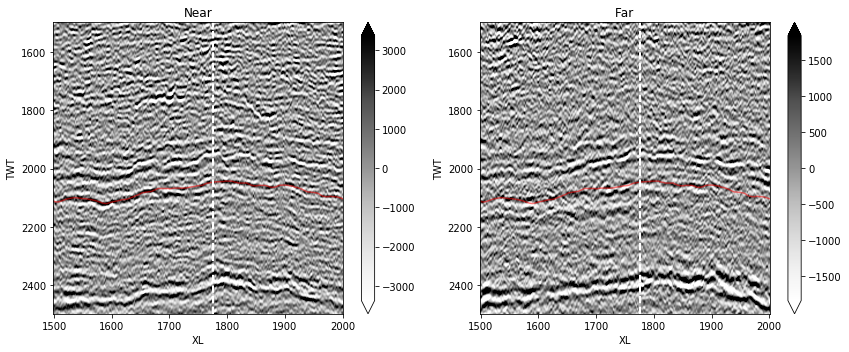

In [7]:
inline=1376
uu={'robust':True,'interpolation':'spline16','cmap':'Greys'}

f, ax = plt.subplots(nrows=1,ncols=2,figsize=(12,5))
near.sel(IL=1376).plot.imshow(x='XL',y='TWT',yincrease=False,ax=ax[0],**uu)
ax[0].plot(hrz[hrz['il']==inline]['xl'],hrz[hrz['il']==inline]['z'],color='r',alpha=0.5,label='Top Heimdal')
ax[0].axvline(well2_xl,color='w',ls='--',lw=2)
ax[0].set_title('Near')

far.sel(IL=1376).plot.imshow(x='XL',y='TWT',yincrease=False,ax=ax[1],**uu)
ax[1].plot(hrz[hrz['il']==inline]['xl'],hrz[hrz['il']==inline]['z'],color='r',alpha=0.5,label='Top Heimdal')
ax[1].axvline(well2_xl,color='w',ls='--',lw=2)
ax[1].set_title('Far'),

plt.tight_layout()

#### Extract inline to fasten the computation

In [8]:
near_il = near.sel(IL=1376)
far_il = far.sel(IL=1376)

angle_n=np.sin(np.radians(5))**2
angle_f=np.sin(np.radians(25))**2
G = (far_il - near_il)/(angle_f-angle_n)
I = near_il - G*angle_n

#### Crossplots

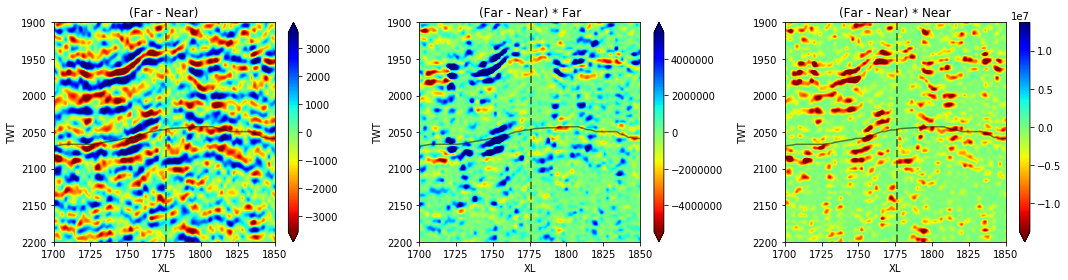

In [9]:
near_ilzoom=near_il.sel(TWT=slice(1900,2200),XL=slice(1700,1850))
far_ilzoom=far_il.sel(TWT=slice(1900,2200),XL=slice(1700,1850))

far_near = far_ilzoom - near_ilzoom
far_near_far = (far_ilzoom - near_ilzoom) * far_ilzoom
far_near_near = (far_ilzoom - near_ilzoom) * near_ilzoom

uu={'add_colorbar':True,'robust':True,'interpolation':'spline16','cmap':'jet_r'}

f, ax = plt.subplots(nrows=1,ncols=3,figsize=(15,4))
far_near.plot.imshow(x='XL',y='TWT',yincrease=False,ax=ax[0],**uu)
ax[0].set_title('(Far - Near)')
ax[0].plot(hrz[hrz['il']==inline]['xl'],hrz[hrz['il']==inline]['z'],color='k',alpha=0.5,label='Top Heimdal')
ax[0].set_xlim(1700,1850)
ax[0].set_ylim(2200,1900)
ax[0].axvline(well2_xl,color='k',alpha=0.5,ls='--',lw=2)

far_near_far.plot.imshow(x='XL',y='TWT',yincrease=False,ax=ax[1],**uu)
ax[1].set_title('(Far - Near) * Far')
ax[1].plot(hrz[hrz['il']==inline]['xl'],hrz[hrz['il']==inline]['z'],color='k',alpha=0.5,label='Top Heimdal')
ax[1].set_xlim(1700,1850)
ax[1].set_ylim(2200,1900)
ax[1].axvline(well2_xl,color='k',alpha=0.5,ls='--',lw=2)

far_near_near.plot.imshow(x='XL',y='TWT',yincrease=False,ax=ax[2],**uu)
ax[2].set_title('(Far - Near) * Near')
ax[2].plot(hrz[hrz['il']==inline]['xl'],hrz[hrz['il']==inline]['z'],color='k',alpha=0.5,label='Top Heimdal')
ax[2].set_xlim(1700,1850)
ax[2].set_ylim(2200,1900)
ax[2].axvline(well2_xl,color='k',alpha=0.5,ls='--',lw=2)

plt.tight_layout()

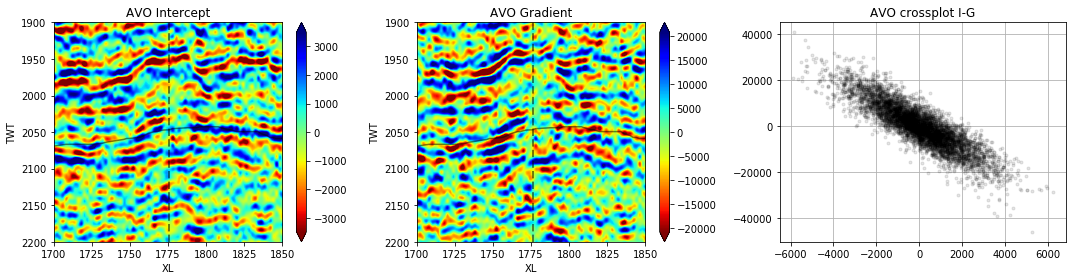

In [10]:
Izoom=I.sel(TWT=slice(1900,2200),XL=slice(1700,1850))
Gzoom=G.sel(TWT=slice(1900,2200),XL=slice(1700,1850))

uu={'add_colorbar':True,'robust':True,'interpolation':'spline16','cmap':'jet_r'}

f, ax = plt.subplots(nrows=1,ncols=3,figsize=(15,4))
Izoom.plot.imshow(x='XL',y='TWT',yincrease=False,ax=ax[0],**uu)
ax[0].set_title('AVO Intercept')
ax[0].plot(hrz[hrz['il']==inline]['xl'],hrz[hrz['il']==inline]['z'],color='k',alpha=0.5,label='Top Heimdal')
ax[0].set_xlim(1700,1850)
ax[0].set_ylim(2200,1900)
ax[0].axvline(well2_xl,color='k',alpha=0.5,ls='--',lw=2)

Gzoom.plot.imshow(x='XL',y='TWT',yincrease=False,ax=ax[1],**uu)
ax[1].set_title('AVO Gradient')
ax[1].plot(hrz[hrz['il']==inline]['xl'],hrz[hrz['il']==inline]['z'],color='k',alpha=0.5,label='Top Heimdal')
ax[1].set_xlim(1700,1850)
ax[1].set_ylim(2200,1900)
ax[1].axvline(well2_xl,color='k',alpha=0.5,ls='--',lw=2)

ax[2].plot(Izoom,Gzoom,'.k',alpha=0.1)
ax[2].set_title('AVO crossplot I-G')
ax[2].grid()

plt.tight_layout()

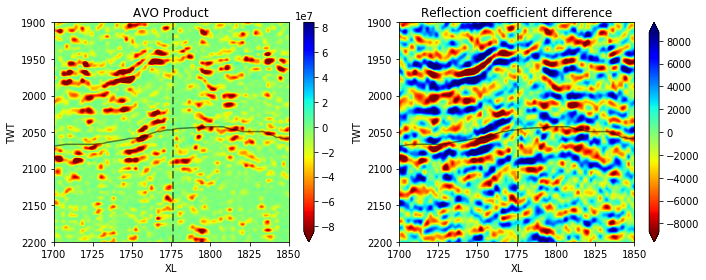

In [11]:
Izoom=I.sel(TWT=slice(1900,2200),XL=slice(1700,1850))
Gzoom=G.sel(TWT=slice(1900,2200),XL=slice(1700,1850))

IG = Izoom*Gzoom
Rp_Rs = (I + G)*0.5

uu={'add_colorbar':True,'robust':True,'interpolation':'spline16','cmap':'jet_r'}

f, ax = plt.subplots(nrows=1,ncols=2,figsize=(10,4))
IG.plot.imshow(x='XL',y='TWT',yincrease=False,ax=ax[0],**uu)
ax[0].set_title('AVO Product')
ax[0].plot(hrz[hrz['il']==inline]['xl'],hrz[hrz['il']==inline]['z'],color='k',alpha=0.5,label='Top Heimdal')
ax[0].set_xlim(1700,1850)
ax[0].set_ylim(2200,1900)
ax[0].axvline(well2_xl,color='k',alpha=0.5,ls='--',lw=2)

Rp_Rs.plot.imshow(x='XL',y='TWT',yincrease=False,ax=ax[1],**uu)
ax[1].set_title('Reflection coefficient difference')
ax[1].plot(hrz[hrz['il']==inline]['xl'],hrz[hrz['il']==inline]['z'],color='k',alpha=0.5,label='Top Heimdal')
ax[1].set_xlim(1700,1850)
ax[1].set_ylim(2200,1900)
ax[1].axvline(well2_xl,color='k',alpha=0.5,ls='--',lw=2)

plt.tight_layout()

## References

Alessandro del Monte - Playing with seismic https://github.com/aadm/geophysical_notes/blob/master/playing_with_seismic.ipynb

Alessandro del Monte - Seismic amplitude extraction https://github.com/aadm/geophysical_notes/blob/master/seismic_amplitude_extraction.ipynb

Avseth, P., Mukerji, T., & Mavko, G., 2010. Quantitative seismic interpretation: Applying rock physics tools to reduce interpretation risk. Cambridge university press.

Castagna, J. P., and Smith, S. W., 1994. Comparison of AVO indicators: A modeling study. Geophysics, 59, 1849-1855.

Ross, C. P., and Kinman, D. L., 1995. Nonbright-spot AVO; two examples. Geophysics, 60(5), 1398-1408.

The dataset: https://srb.stanford.edu/quantitative-seismic-interpretation